# Project 6 - Intro to Deep Learning Image Classification

### Due Date: *Wednesday, April 17th*

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

Please also fill in here the time that each part took you:
1. Part A - Dataset: <span style="color:red;">1 hour</span>
2. Part B - Neural Network Architecture: <span style="color:red;">1 hour</span>
3. Part C - Network Training: <span style="color:red;">3 hours</span>
4. Part D - Testing: <span style="color:red;">2 hours</span>
5. Write-up: <span style="color:red;">20 minutes</span>

## Background - Image Classification

For this project you will be introduced to the basics of deep learning and the PyTorch framework.  Deep learning can be very computationally expensive and runs fastest with GPU support.  If you do not have access to GPUs on your local machine, you can use some from Google using their [colab tool](https://colab.research.google.com).  Colab runs exactly like jupyter notebooks and you can directly upload your .ipynb file.

Image classification is the task of taking an image and labeling it as a category.  Deep learning has been the leading method for image classification since it dominated the [ImageNet competition in 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

# Part A: Dataset

You will be performing classification on the [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), which consists of 16,185 images of 196 classes of cars.  The dataset is split 50-50 into a training set and testing set.  You will want to download each one idividually from Stanford's site or use these links: [Train Set](http://imagenet.stanford.edu/internal/car196/cars_train.tgz) and [Test Set](http://imagenet.stanford.edu/internal/car196/cars_test.tgz).  Each set is around 1 GB of data so please **<span style="color:red">DO NOT</span>** include the files when you upload your notebook--**just turn in the .ipynb file**.  Assume the notebooks will be run with the images in folders labeled `cars_train` and `cars_test` like so:

```
.
+--proj6-image-classification.ipynb
+--cars_train
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--cars_test
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--test_annos.json
+--train_annos.json
```

The first step in any deep learning method is to make sure you can read in the data.  Since there will be a lot of images for this project, it is possible not all of them will fit into memory.  This is a common problem in deep learning and PyTorch has provided a pattern so as to only have the images you need in memory at a time.  They provide a class called `DataLoader` that acts as an iterable object.  To use `DataLoader`, you will need to implement a subclass of PyTorches `Dataset` class.  To do you so will need to create a class that inherits from `Dataset` and implements the methods `__getitem__` and `__len__`.  An example is given below and PyTorch provides a [tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html):

```Python
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self):
        super(MyDataset, self).__init__()
#         TODO: implement what happens when someone calls: 
#         dataset = MyDataset()
    
    def __getitem__(self, idx):
#         TODO: implement what happens when someone calls dataset[idx]
#         This typically will return an image and its label 
    
    def __len__(self):
#         TODO: implement what happens when someone calls len(dataset)

dataset = MyDataset()
loader = DataLoader(dataset)
for im, label in loader:
#     TODO: Perform operations
```

We provide you with two files `test_annos.json` and `train_annos.json`.  These files contain a dictionary mapping image name to the class label the image belongs to.  You can use these files in you Dataset class in order to provide the ground truth labels.  For part A, you will need to implement a dataset class.

In [1]:
from torch.utils.data import Dataset, DataLoader
import os
import json
from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import torch.nn as nn
from torchvision import transforms, utils
from tqdm import tqdm
import pickle
import mag

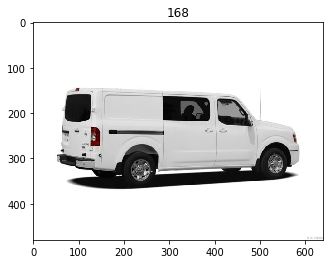

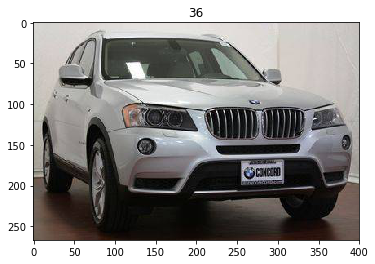

In [2]:
class CarsDataset(Dataset):
    def __init__(self, test=False, transform=None):
        super().__init__()
        self._test = test
        self._transform = transform
        
        if self._test:
            self._root = 'cars_test'
            annos = 'test_annos.json'
            self._len = 8041
        else:
            self._root = 'cars_train'
            annos = 'train_annos.json'
            self._len = 8144
        
        # Load labels
        with open(annos, 'rb') as fp:
            self._annos = json.load(fp)
            
        

    def __getitem__(self, idx):
        img_name = "{:05}.jpg".format(idx+1) # they start at 1, not 0
        path = os.path.join(self._root, img_name) 
        img = io.imread(path)
        if img.ndim == 2: # There's a single grayscale image in the test set
            img = np.stack([img, img, img], axis=0) # Make it color
            
        if self._transform:
            img = self._transform(img)
            
        label = self._annos[img_name] - 1 # labels start at 1, not 0
        return img, label

    def __len__(self):
        return self._len
    
train_dataset_notransform = CarsDataset(test=False) # This only works for testing; don't feed it into our model.
test_dataset_notransform = CarsDataset(test=True) # We need transforms first

def get_image(dataset):
    img, label = dataset[np.random.randint(len(dataset))]
    plt.imshow(img)
    plt.title(label)
    plt.show()
    return img, label

train_img, _ = get_image(train_dataset_notransform)
test_img, _ = get_image(test_dataset_notransform)

# Part B: Neural Network Architecture

The main backbone for deep learning is the actual neural network architecture.  For image classification, this will consist of some combination of `Conv2d` layers with activations--usually `ReLU`--with intermitted downsampling--usually done using `MaxPool2d`--followed by a few Linear layers.  The input to the network should be an image with shape `(batch_size, channels, image_height, image_width)`(e.g. an single image with dimensions 224x224 would be `(1, 3, 224, 224)`) and output a vector of shape `(num_classes,)` where the largest value's index in the output vector indicates the class label.  

While we built our own network in the Learning Lab, for this lab we will used one of Pytorch's pretrained networks. This has the benefit of already having learned features from training on an ImageNet classification problem. To pull in this pretrained network, we use the following line of code:


In [3]:
class CarsResnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(in_features=512, out_features=196)
        
    def forward(self, x):
        return self.model(x)

The ResNet18 is a state of the art network that uses convolution layers, batch normalization, layers of residual blocks, and a fully connected layer at the end. The different layers are listed above. However, because the pretrained network was trained on ImageNet, the last layer is designed to predict 1000 classes, not 196 like in our dataset.

Our goal is to use the same architecture as the ResNet, but replace the last fully connected layer with a new fully connected layer that goes from 512 input features to 196 output features.

PyTorch provides a nice framework for making a neural network architecture.  A network is typically made as a class that inherits from PyTorch's `Module` class and implments the `forward` method.  A network might take the form of the example below. PyTorch also provides a simple Neural Network [tutorial here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), the Training a Classifier tutorial is especially helpful.
```Python
import torch.nn as nn 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
#         TODO: setup network here

    def forward(self, x):
#         TODO: perform the forward pass, which happens when someone calls network(x)
```

Take all the pretrained layers from ResNet18, but then define your own last fully connected layer. Then write the appropriate forward pass function.

# Part C: Training

Now that you can access your data and you have a network architecture setup, its time to put things together and start training.  Training requires two major components: 1) the loss function and 2) the optimizer.  The loss function is a comparison between your results and the ground truth data.  The optimizer is what takes the results of the loss function and backpropagates the error to the network weights in an attempt to decrease the loss.  The most common loss functions used for classification is [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) while the most commonly used optimizer function is [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).  

A basic training step might take the following form:
```Python
optimizer.zero_grad()
outs = model(inputs)
loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
loss.backward()
optimizer.step()  # optimizer would be an instance of the torch.optim.Adam class
```

For deliverables on this section, please display a plot of the value of the loss over time.  If things are working, the loss should be decreasing.

*note: This step could take several hours so you will want to look into being able to save your model to a file and load it up again*

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

train_dataset = CarsDataset(test=False, transform=data_transforms['test'])
test_dataset = CarsDataset(test=True, transform=data_transforms['test'])

In [5]:
def test_accuracy(model, data_loader, n_iters=None):
    total_correct = 0
    total_seen = 0

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            labels_pred = outputs.argmax(dim=1)
            n_correct = (labels_pred == labels).float().sum()
            n_seen = labels.shape[0]
            total_correct += n_correct
            total_seen += labels.shape[0]
            
            if n_iters is not None and i == n_iters:
                break

    test_acc = total_correct / total_seen
    return test_acc

In [6]:
def train_and_save(batch_size):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
    print("Batch size {}, Batches per Epoch: {}".format(batch_size, len(train_loader)))
    
    model = CarsResnet().to(device)
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        total_loss = 0
        total_correct = 0
        total_images = 0
        progress = tqdm(train_loader)
        for i, batch in enumerate(progress):
            optimizer.zero_grad()
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            
            total_loss += loss.item()
            n_correct = (outputs.argmax(dim=1) == labels).sum().item()
            total_correct += n_correct
            total_images += len(labels)

            loss.backward()
            optimizer.step()
            
            progress.set_description('train loss: {:.3f}, batch acc: {:.3f}'.format(loss.item(), n_correct / len(labels)))
#             if i == 1:
#                 break
        
        avg_loss = total_loss / len(train_loader)
        train_acc = total_correct / total_images
        test_acc = test_accuracy(model, test_loader, n_iters=5)
        print("Epoch {}, train loss {:.3f}, train acc {:.3f}, test acc {:.3f}".format(epoch, avg_loss, train_acc, test_acc))

    return model, train_acc, test_acc

n_epochs = 50
n_print_every = 25
lr = 1e-3
# batch_size = 128 # error occurs only with batch size 32, not 16 or below
batch_size_test = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device {}".format(device))

# model.to(device)

train_accs, test_accs = [], []
batch_sizes = [128]
for batch_size in batch_sizes:
    model, train_acc, test_acc = train_and_save(batch_size)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
print(train_accs, test_accs)
obj = {
    'batch_sizes': batch_sizes,
    'train_accs': train_accs,
    'test_accs': test_accs
}

with open('batch_test.pickle', 'wb') as handle:
    pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('batch_test.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
print("done")
print(b)

device cuda
Batch size 128, Batches per Epoch: 64


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 0, train loss 4.009, train acc 0.153, test acc 0.354


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1, train loss 1.763, train acc 0.575, test acc 0.585


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2, train loss 0.723, train acc 0.832, test acc 0.657


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 3, train loss 0.273, train acc 0.946, test acc 0.708


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 4, train loss 0.105, train acc 0.985, test acc 0.738


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 5, train loss 0.044, train acc 0.993, test acc 0.773


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6, train loss 0.023, train acc 0.996, test acc 0.755


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7, train loss 0.017, train acc 0.997, test acc 0.782


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 8, train loss 0.014, train acc 0.997, test acc 0.786


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9, train loss 0.013, train acc 0.996, test acc 0.779


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10, train loss 0.014, train acc 0.997, test acc 0.760


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 11, train loss 0.015, train acc 0.996, test acc 0.745


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12, train loss 0.035, train acc 0.993, test acc 0.710


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 13, train loss 0.194, train acc 0.954, test acc 0.525


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 14, train loss 0.910, train acc 0.741, test acc 0.564


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15, train loss 0.327, train acc 0.907, test acc 0.678


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 16, train loss 0.095, train acc 0.975, test acc 0.714


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17, train loss 0.029, train acc 0.993, test acc 0.748


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 18, train loss 0.015, train acc 0.996, test acc 0.757


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19, train loss 0.010, train acc 0.997, test acc 0.768


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 20, train loss 0.008, train acc 0.997, test acc 0.752


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 21, train loss 0.008, train acc 0.997, test acc 0.770


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 22, train loss 0.007, train acc 0.997, test acc 0.751


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 23, train loss 0.006, train acc 0.997, test acc 0.771


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24, train loss 0.006, train acc 0.997, test acc 0.766


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25, train loss 0.005, train acc 0.997, test acc 0.764


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 26, train loss 0.006, train acc 0.997, test acc 0.753


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27, train loss 0.006, train acc 0.997, test acc 0.756


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28, train loss 0.005, train acc 0.997, test acc 0.764


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29, train loss 0.005, train acc 0.997, test acc 0.784


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30, train loss 0.005, train acc 0.997, test acc 0.755


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 31, train loss 0.005, train acc 0.997, test acc 0.762


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 32, train loss 0.005, train acc 0.997, test acc 0.777


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 33, train loss 0.005, train acc 0.997, test acc 0.780


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 34, train loss 0.005, train acc 0.997, test acc 0.773


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 35, train loss 0.005, train acc 0.997, test acc 0.771


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 36, train loss 0.005, train acc 0.998, test acc 0.768


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 37, train loss 0.005, train acc 0.997, test acc 0.775


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 38, train loss 0.005, train acc 0.997, test acc 0.773


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 39, train loss 0.005, train acc 0.998, test acc 0.769


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 40, train loss 0.005, train acc 0.997, test acc 0.773


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 41, train loss 0.005, train acc 0.997, test acc 0.764


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 42, train loss 0.005, train acc 0.997, test acc 0.788


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 43, train loss 0.005, train acc 0.998, test acc 0.759


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 44, train loss 0.005, train acc 0.997, test acc 0.770


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 45, train loss 0.019, train acc 0.995, test acc 0.669


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 46, train loss 1.242, train acc 0.676, test acc 0.492


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 47, train loss 0.593, train acc 0.827, test acc 0.630


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 48, train loss 0.106, train acc 0.972, test acc 0.691


train loss: 0.011, batch acc: 1.000: 100%|██████████| 64/64 [02:58<00:00,  2.79s/it]


Epoch 49, train loss 0.029, train acc 0.994, test acc 0.715
[0.9942288801571709] [tensor(0.7155, device='cuda:0')]
done
{'batch_sizes': [128], 'train_accs': [0.9942288801571709], 'test_accs': [tensor(0.7155, device='cuda:0')]}


{'batch_sizes': [128], 'train_accs': [0.9942288801571709], 'test_accs': [tensor(0.7155, device='cuda:0')]}


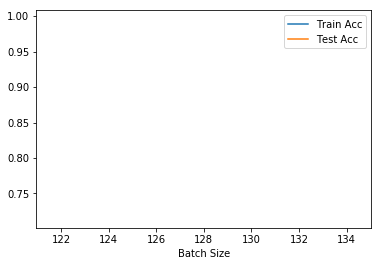

In [7]:
with open('batch_test.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
batch_sizes, train_accs, test_accs = b['batch_sizes'], b['train_accs'], b['test_accs']
print(b)
plt.plot(batch_sizes, train_accs, label="Train Acc")
plt.plot(batch_sizes, test_accs, label="Test Acc")
plt.legend()
plt.xlabel("Batch Size")
plt.show()

# Part D: Testing

One of the goals of deep learning is to make a model that generalizes to data it has never seen (e.g. new images of cars).  For this part, you will test your generalizability by running the model on a dataset it has not yet seen during training.  To do so, you will also need to put the model into  you will need to make sure you are not calculating any of the gradients by using `torch.no_grad` in a with statement. You will aslo need to put the network into evaluation mode:
```Python
model.eval()
with torch.no_grad():
    # enter testing code here
```

To put the network back into training mode, call `model.train()`.

You will also need to compare your actual predictions with the ground truth value for value.  The output of your network, however, will be a vector of length 196 (the number of possible classes for the cars dataset) with the largest value representing the guessed class.  You'll need to extract the guessed class number and compare it with the ground truth number for all images in the test dataset and calculate the overall accuracy.  Print out the overall accuacy your model got. 

In [11]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
acc = test_accuracy(model, test_loader)
print("Test Accuracy: {:.3f}".format(acc))

Test Accuracy: 0.723


## Grading
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Making a Dataset class
* [20 pts] Setting up you architecture
* [20 pts] Training your model
* [20 pts] Displaying the accuracy of your model

The last 20 points are earned through completing a subset of the following explorations:
* [10 pts] Enhance your dataloader to include reflection data augmentation (i.e. double the size of your training data by taking the mirror image across the y-axis). **DO NOT** do reflection augmentation across the x-axis (we don't care to detect cars when they are upside down!).
* [10 pts] Enhance your dataloader to include random crop data augmentation (i.e. increase the size of your training data by taking a subsection of your image each time). Make sure the crop is not too small, otherwise you might miss parts of the car. 
* [10 pts] Analyze the effect of learning rates and epochs on the accuracy of the network. Describe what you found and give supporting plots. A list of optimizers in Pytorch can be found [here](https://pytorch.org/docs/stable/optim.html).
* [10 pts] Analyze the effect of batch_size and varying optimizers on the accuracy of the network. Describe what you found and give supporting plots. 
* [10 pts] Analyze the effect of different pretrained networks on the accuracy of the network. Describe what you found and give supporting plots. A list of pretrained networks in Pytorch can be found [here](https://pytorch.org/docs/stable/torchvision/models.html).

You may earn up to 10 points extra credit for additional explorations you complete.

An additional 15 points of extra credit will be given to the individual with the highest test accuracy.

# Writeup
Extra credit:
    10 points for reflection data augmentation
    10 points for random crop data augmentation
    10 points for the effect of batch size on the network
    
Batch size seems to have a sweet spot around 128 or 256. Any lower and the gradients are too noisy to converge to a near-optimal minimum; any higher and there isn't enough variance to escape local minima.